In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [2]:
class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def yield_tokens(texts):
    for text in texts:
        yield tokenizer(text)

In [3]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

In [4]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        if batch_idx % 5 == 0:
            print(f'Epoch: {epoch + 1}, Iterations: {batch_idx}, Loss: {loss.item()}')

    return running_loss / len(train_loader), correct / total


def evaluate(model, test_loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return running_loss / len(test_loader), correct / total

In [5]:
torch.manual_seed(7)

# Load the data
data = pd.read_csv('training.csv', usecols=['text', 'author'], sep=',', encoding='ISO-8859-1')
texts = data['text']  # Extract the text column
labels = data['author'] - 1  # Extract the label column

# Tokenize the text and create the vocabulary
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(yield_tokens(texts), min_freq=1, specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab['<unk>'])

# Convert the text into numerical sequences
sequences = [torch.tensor([vocab[token] for token in tokenizer(text)]) for text in texts]

# Pad the sequences to a fixed length
max_sequence_length = 1000
sequences = pad_sequence(sequences, batch_first=True, padding_value=vocab['<pad>'])
sequences = sequences[:, :max_sequence_length]

# Encode the labels into integers
num_classes = 50
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)


In [6]:
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [25]:
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 400
output_dim = num_classes
num_layers = 3

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Learning rate scheduler
# scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=int(num_epochs / 5), T_mult=4, eta_min=1e-6)


useTwoGPUs = True
if torch.cuda.device_count() > 1 and useTwoGPUs:
    print(f'Using {torch.cuda.device_count()} GPUs')
    model = nn.DataParallel(model)

cpu


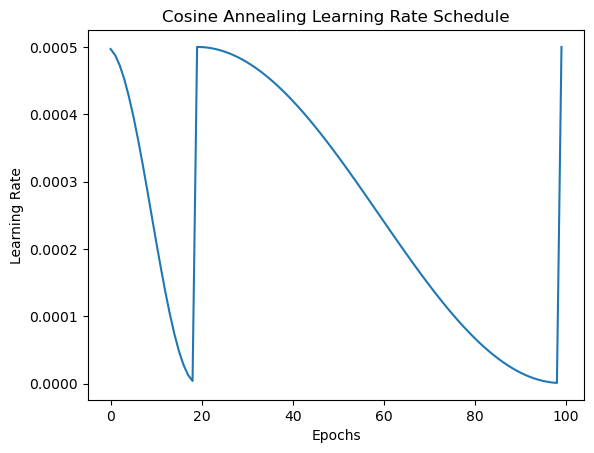

In [26]:
# import matplotlib.pyplot as plt
# import numpy as np
#
# epochs = num_epochs
# lr = []
# for i in range(epochs):
#     scheduler.step()
#     lr.append(optimizer.param_groups[0]['lr'])
#
# plt.plot(np.arange(epochs), lr)
# plt.xlabel('Epochs')
# plt.ylabel('Learning Rate')
# plt.title('Cosine Annealing Learning Rate Schedule')
# plt.show()

In [ ]:
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device, epoch)

    print(
        f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

    scheduler.step()

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
